In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pip

/tmp/ipykernel_3168435/3239068334.py:1: DtypeWarning: Columns (4,5,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cpal_eviction/data/NTEP_eviction_cases.csv')


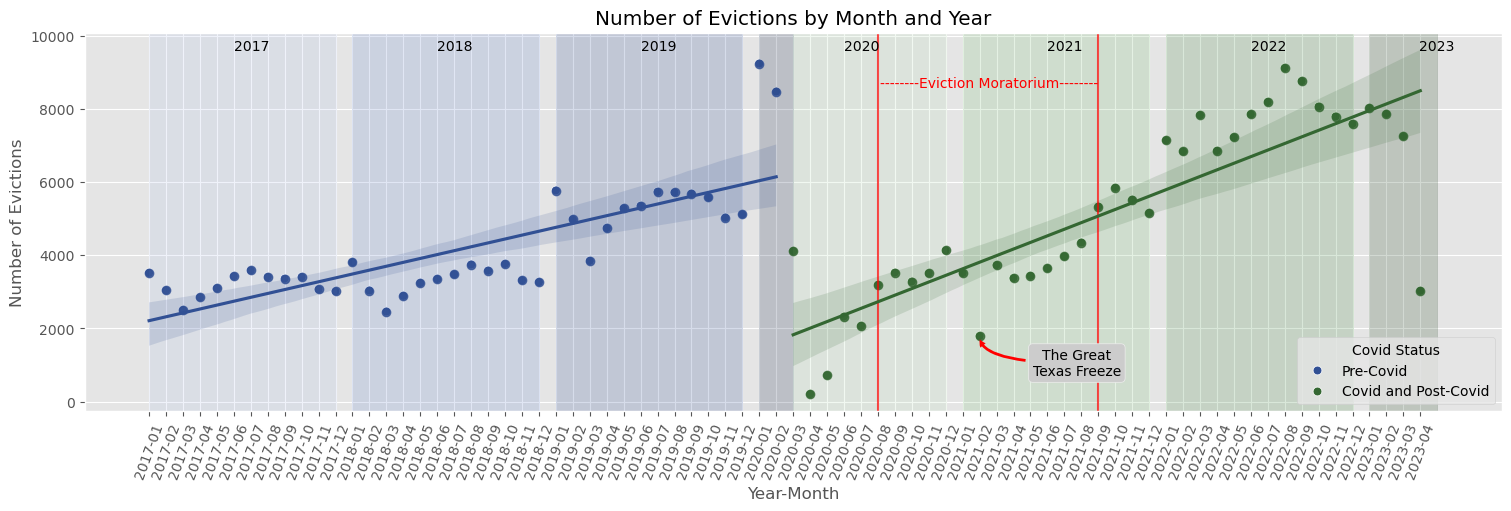

In [2]:
data = pd.read_csv('cpal_eviction/data/NTEP_eviction_cases.csv')

evict_yr_mo = []
evict_mo = []
for i in data['date'].astype(str):
    if len(i.split('-')) > 2:
        evict_yr_mo.append(i.split('-')[0] + '-' + i.split('-')[1])
        evict_mo.append(i.split('-')[1])
    else:
        evict_yr_mo.append(i.split('-')[0])
        evict_mo.append('Na')

data['yr_mo'] = evict_yr_mo

data_comp = data[data['yr_mo'] != '2023-07']
data_comp_group = data_comp.groupby('yr_mo').nunique()
data_comp_group['yr_mo_col'] = data_comp_group.index
data_comp_group['yr_mo_col_num'] = data_comp_group['yr_mo_col'].str.replace('-','').astype(float)
data_comp_group['yr_mo_col_ord'] = range(len(data_comp_group['yr_mo_col_num']))


mo = []
for i in data_comp_group['yr_mo_col']:
    mo.append(i.split('-')[1])
    
data_comp_group['mo'] = mo

covid_status = []
for i in data_comp_group['yr_mo_col_num']:
    if i < 202003:
        covid_status.append('Pre-Covid')
    else:
        covid_status.append('Covid and Post-Covid')
        
data_comp_group['covid_status'] = covid_status

plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), layout='constrained')

# Add scatterplot + legend
pre_col = '#315094'
post_col = '#346732'
cov_colors = {'Pre-Covid': pre_col, 'Covid and Post-Covid': post_col}
scatter = sns.scatterplot(data=data_comp_group, x='yr_mo_col', y='case_number', palette=cov_colors,
                          ax=ax, hue='covid_status', s=40).set(title='Number of Evictions by Month and Year', 
                                           ylabel='Number of Evictions', xlabel='Year-Month');

ax.legend(loc=4, ncol=1, title='Covid Status')#, labels=['Pre-Covid', 'Covid and Post-Covid'])

# Add annotation by year
yr_alpha = 0.2
text_y = 9600
ax.axvspan('2017-01', '2017-12', color='#B2C2E6', alpha=yr_alpha)
ax.annotate('2017', xy =('2017-06', text_y), ha='left')
ax.axvspan('2018-01', '2018-12', color='#6686CC', alpha=yr_alpha)
ax.annotate('2018', xy =('2018-06', text_y), ha='left')
ax.axvspan('2019-01', '2019-12', color='#335399', alpha=yr_alpha)
ax.annotate('2019', xy =('2019-06', text_y), ha='left')

ax.axvspan('2020-01', '2020-03', color='#192A4D', alpha=yr_alpha)
ax.axvspan('2020-03', '2020-12', color='#BBDEBA', alpha=yr_alpha)

ax.annotate('2020', xy =('2020-06', text_y), ha='left')
ax.axvspan('2021-01', '2021-12', color='#78BD75', alpha=yr_alpha)
ax.annotate('2021', xy =('2021-06', text_y), ha='left')
ax.axvspan('2022-01', '2022-12', color='#458A42', alpha=yr_alpha)
ax.annotate('2022', xy =('2022-06', text_y), ha='left')
ax.axvspan('2023-01', '2023-06', color='#224521', alpha=yr_alpha)
ax.annotate('2023', xy =('2023-05', text_y), ha='right')

# Add moratorium to graph
mora_color = 'red'
ax.axvline('2020-08', color=mora_color, alpha=0.7)
ax.axvline('2021-09', color=mora_color, alpha=0.7)
ax.annotate('--------Eviction Moratorium--------', xy =('2021-09', text_y-1000), ha='right', color=mora_color)

# Add regression plots
pol_order=1
lin_plot_pre = sns.regplot(x ='yr_mo_col_ord', y ='case_number', order=1, color=pre_col,
                       data = data_comp_group[data_comp_group['covid_status']=='Pre-Covid'], ax=ax);

lin_plot_post = sns.regplot(x ='yr_mo_col_ord', y ='case_number', order=1, color=post_col,
                       data = data_comp_group[data_comp_group['covid_status']=='Covid and Post-Covid'], ax=ax).set(title='Number of Evictions by Month and Year', 
                                           ylabel='Number of Evictions', xlabel='Year-Month');

# Label freeze
bbox = dict(boxstyle ="round", fc ="0.8")
arrowprops=dict(arrowstyle="simple",
                            color='red', ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90")
ax.annotate('The Great\nTexas Freeze', xy=('2021-02', 1780), xytext=(70, -30), 
            textcoords='offset points', ha='center', va='bottom',
            bbox = bbox, arrowprops = arrowprops)

# Adjust x-axis labels
ax.set_xticks(range(len(data_comp_group)));
ax.set_xticklabels(data_comp_group['yr_mo_col']);
plt.xticks(rotation=70);

plt.savefig('cpal_eviction_public/results/evictionmonths.png', dpi=1200)

In [3]:
evict_rec_2022 = pd.read_excel("cpal_eviction/data/DallasCounty_EvictionRecords.xlsx")
evict_jud_2022 = pd.read_excel("cpal_eviction/data/DallasCounty_EvictionJudgements.xlsx")
evict_hist_2022 = pd.read_excel("cpal_eviction/data/DallasCounty_HistoricalEvictionRecords.xlsx")
jud_geo = pd.read_csv("cpal_eviction/data/judgements_GEOIDS.csv")


In [4]:
def def_names(df):
    df['def_business'] = 0
        
    # Sort out defendent names containing a key word
    key_words = [' INC', ' LLC', 'SHOP', ' LLP', 'RESTAURANT', 'PARTNER', 'CORP']
    for key in key_words:
        df.loc[df['defendant_name'].str.contains(key), 'def_business'] = 1
    
    return(df)

In [5]:
evict_hist_def_names = def_names(evict_hist_2022)
# Number of businesses = 454
len(evict_hist_def_names[evict_hist_def_names['def_business'] == 1]['defendant_name'])
# Total number of defendants = 185234
len(evict_hist_def_names)
# Percentage of businesses = 0.2451
len(evict_hist_def_names[evict_hist_def_names['def_business'] == 1]['defendant_name']) * 100 / len(evict_hist_def_names)

0.24509539285444357

In [6]:
evict_rec_def_names = def_names(evict_rec_2022)
evict_rec_no_bus = evict_rec_def_names[evict_rec_def_names['def_business'] == 0]
jud_geo_def_names = def_names(jud_geo)

In [7]:
jud_geo['judgment_amt'] = jud_geo['judgment_amt'].replace(',','', regex=True).astype(float)
nonzero_jud_geo = jud_geo[jud_geo['judgment_amt'] > 0]

In [8]:
nonzero_jud_geo_no_bus = jud_geo_def_names[jud_geo_def_names['judgment_amt'] > 0]
nonzero_jud_geo_no_bus = nonzero_jud_geo_no_bus[nonzero_jud_geo_no_bus['def_business']==0]
nonzero_jud_geo_no_bus.to_csv("nonzero_jud_geo_no_bus.csv")

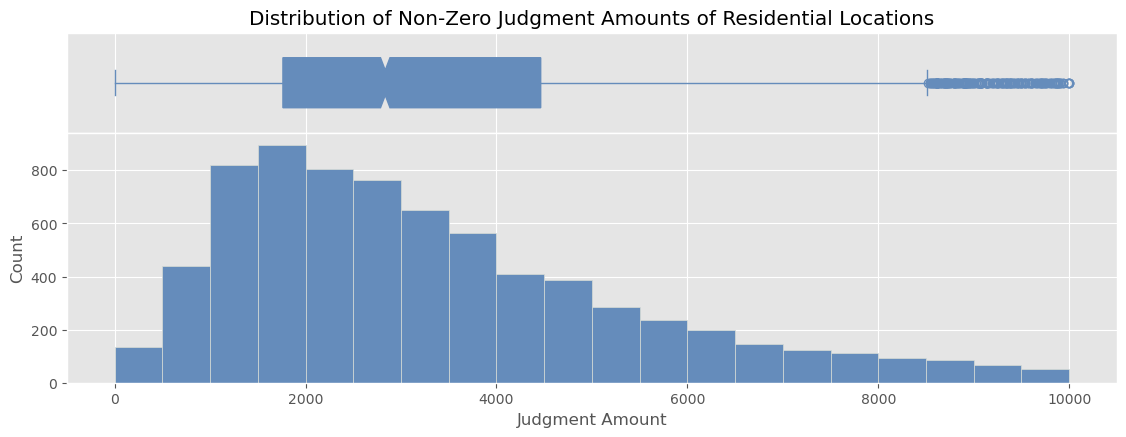

In [9]:

plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
bpAx = fig.add_axes([0.2, 0.7, 0.7, 0.2])   # left, bottom, width, height:
                                            # (adjust as necessary)
histAx = fig.add_axes([0.2, 0.2, 0.7, 0.5]) # left specs should match and
                                            # bottom + height on this line should
                                            # equal bottom on bpAx line
# plot stuff
binwidth = 500
c='xkcd:faded blue'
bp = bpAx.boxplot(nonzero_jud_geo_no_bus['judgment_amt'], notch=True, vert=False, patch_artist=True, widths=0.5,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
h = histAx.hist(nonzero_jud_geo_no_bus['judgment_amt'], color='xkcd:faded blue', edgecolor='xkcd:light gray',
                bins=np.arange(min(nonzero_jud_geo_no_bus['judgment_amt']), max(nonzero_jud_geo_no_bus['judgment_amt']) + binwidth, binwidth))

# confirm that the axes line up 
xlims = np.array([bpAx.get_xlim(), histAx.get_xlim()])
for ax in [bpAx, histAx]:
    ax.set_xlim([xlims.min(), xlims.max()])
    
bpAx.set_title('Distribution of Non-Zero Judgment Amounts of Residential Locations')
ax.set_xlabel('Judgment Amount')
ax.set_ylabel('Count')

bpAx.set_xticklabels([])  # clear out overlapping xlabels
bpAx.set_yticks([])  # don't need that 1 tick mark
plt.savefig('cpal_eviction_public/results/distresidentialnonzero.png')

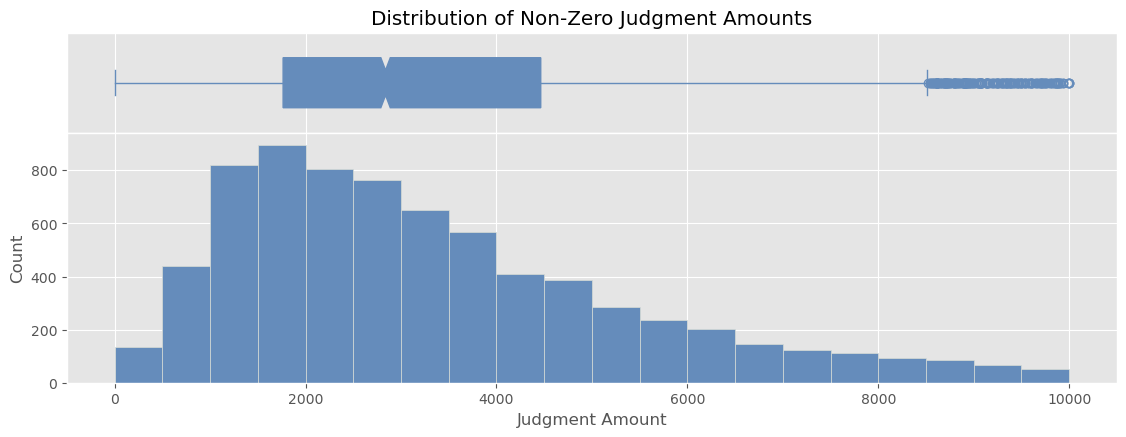

In [10]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
bpAx = fig.add_axes([0.2, 0.7, 0.7, 0.2])   # left, bottom, width, height:
                                            # (adjust as necessary)
histAx = fig.add_axes([0.2, 0.2, 0.7, 0.5]) # left specs should match and
                                            # bottom + height on this line should
                                            # equal bottom on bpAx line
# plot stuff
c='xkcd:faded blue'
bp = bpAx.boxplot(nonzero_jud_geo['judgment_amt'], notch=True, vert=False, patch_artist=True, widths=0.5,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
h = histAx.hist(nonzero_jud_geo['judgment_amt'], color='xkcd:faded blue', edgecolor='xkcd:light gray',
                bins=np.arange(min(nonzero_jud_geo['judgment_amt']), max(nonzero_jud_geo['judgment_amt']) + binwidth, binwidth))

# confirm that the axes line up 
xlims = np.array([bpAx.get_xlim(), histAx.get_xlim()])
for ax in [bpAx, histAx]:
    ax.set_xlim([xlims.min(), xlims.max()])
    
bpAx.set_title('Distribution of Non-Zero Judgment Amounts')
ax.set_xlabel('Judgment Amount')
ax.set_ylabel('Count')

bpAx.set_xticklabels([])  # clear out overlapping xlabels
bpAx.set_yticks([])  # don't need that 1 tick mark
plt.savefig('cpal_eviction_public/results/distnonzerojudge.png')